In [133]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from numba import njit, prange
from tqdm.notebook import tqdm
from utils import metropolis, metropolis2, h, calculate_dE

# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"

In [152]:
L = 64  # Dimensiones de la red
S = np.ones((L, L), dtype=int)
# S = 2*np.random.randint(2,size=(L,L))-1 # Red de -1y1 bidimensional
T = 2.27
beta = 1 / T
dE = np.array([4, 8])  # únicos Delta_E positivos
prob = np.exp(-beta * dE)

Neq = 50_000  # Nro de pasos para el equilibrio
M = np.zeros(Neq)  # Magnetización en función del paso
E = np.zeros(Neq)  # Energía por particula en funcion del paso
M[0] = np.mean(S)  # Promedio de spines
E[0] = h(S)  # Energía por partícula


for n in tqdm(range(1, Neq)):
    #S, E_new, M_new = metropolis(S, prob, 0)
    S, dm, de = metropolis(S, prob)
    M[n] = M[n - 1] + dm
    E[n] = E[n - 1] + de

  0%|          | 0/49999 [00:00<?, ?it/s]

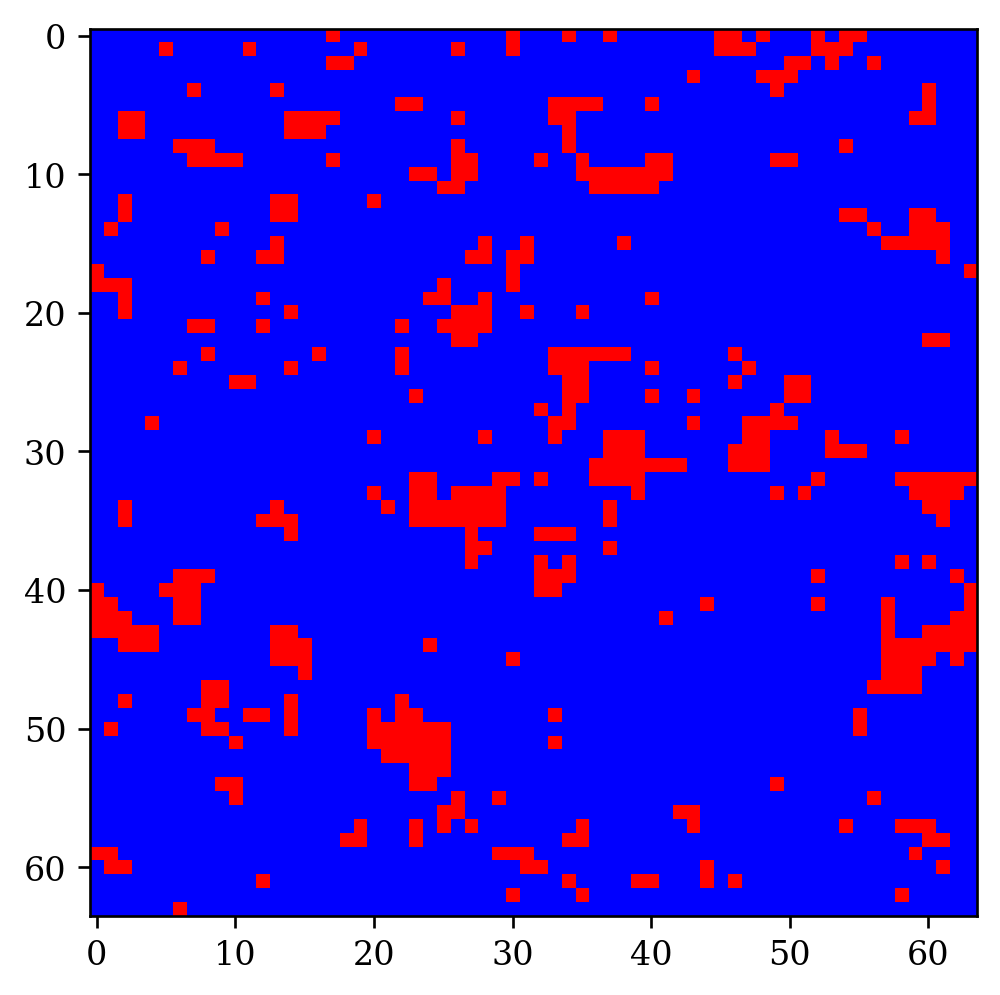

In [153]:
plt.imshow(S, cmap="bwr")
plt.show()

In [154]:
@njit
def cor(S: np.ndarray) -> np.ndarray:
    L = S.shape[0]
    cor_vec = np.zeros(L // 2)
    for r, _ in enumerate(cor_vec):
        cor_filas = np.zeros(L)
        for i in prange(L):
            fila = S[i]
            fila_shift = np.roll(fila, r)
            cor_filas[i] = np.sum(fila * fila_shift)
        cor_vec[r] = np.sum(cor_filas)
    return cor_vec / (L**2)

In [155]:
def cor_fft(S):
    L = S.shape[0]
    S_hat = np.fft.fft(S, axis=1)
    cor = np.sum(np.fft.ifft(S_hat * S_hat.conj(), axis=1), axis=0)
    return np.real(cor[: L // 2]) / S.size

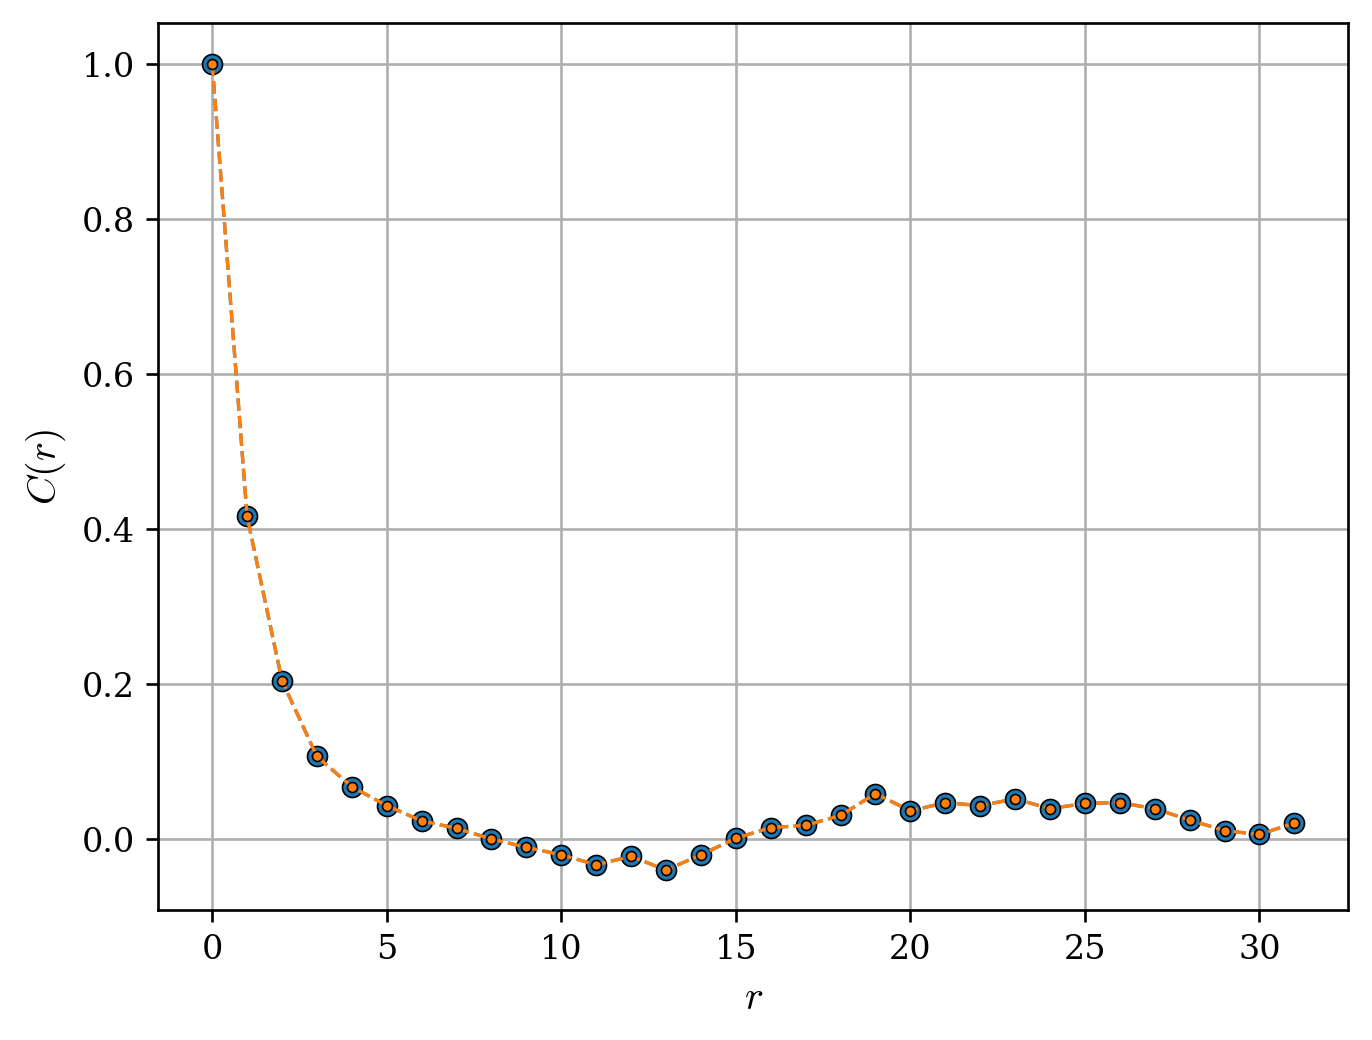

In [168]:
plt.plot(cor(S), "o--", mec="k", mew=0.5, lw=1)
plt.plot(cor_fft(S), ".--", mec="k", mew=0.5, lw=1)
plt.grid()
plt.xlabel("$r$")
plt.ylabel("$C(r)$")
plt.show()

In [164]:

def metropolis2_fft(S: np.ndarray, prob: np.ndarray):
    # Aplica el algoritmo de Metropolis al estado S
    c_original = cor_fft(S)
    # La consigna dice que hay que aplicar el algoritmo de metrópolis por cada
    # sitio en la red, es decir, L cuadrado veces.
    S, dm, _ = metropolis(S, prob)
    dc = cor_fft(S) - c_original
    return S, dm, dc / S.size

Longitud de correlacion:


Temperaturas:   0%|          | 0/3 [00:00<?, ?it/s]

Termalizando:   0%|          | 0/10000 [00:00<?, ?it/s]

Midiendo:   0%|          | 0/999 [00:00<?, ?it/s]

T=1.5 => 0.26649545442348727


Termalizando:   0%|          | 0/10000 [00:00<?, ?it/s]

Midiendo:   0%|          | 0/999 [00:00<?, ?it/s]

T=2.3 => 2.4823652540749355


Termalizando:   0%|          | 0/10000 [00:00<?, ?it/s]

Midiendo:   0%|          | 0/999 [00:00<?, ?it/s]

T=3 => 1.1471250866898939


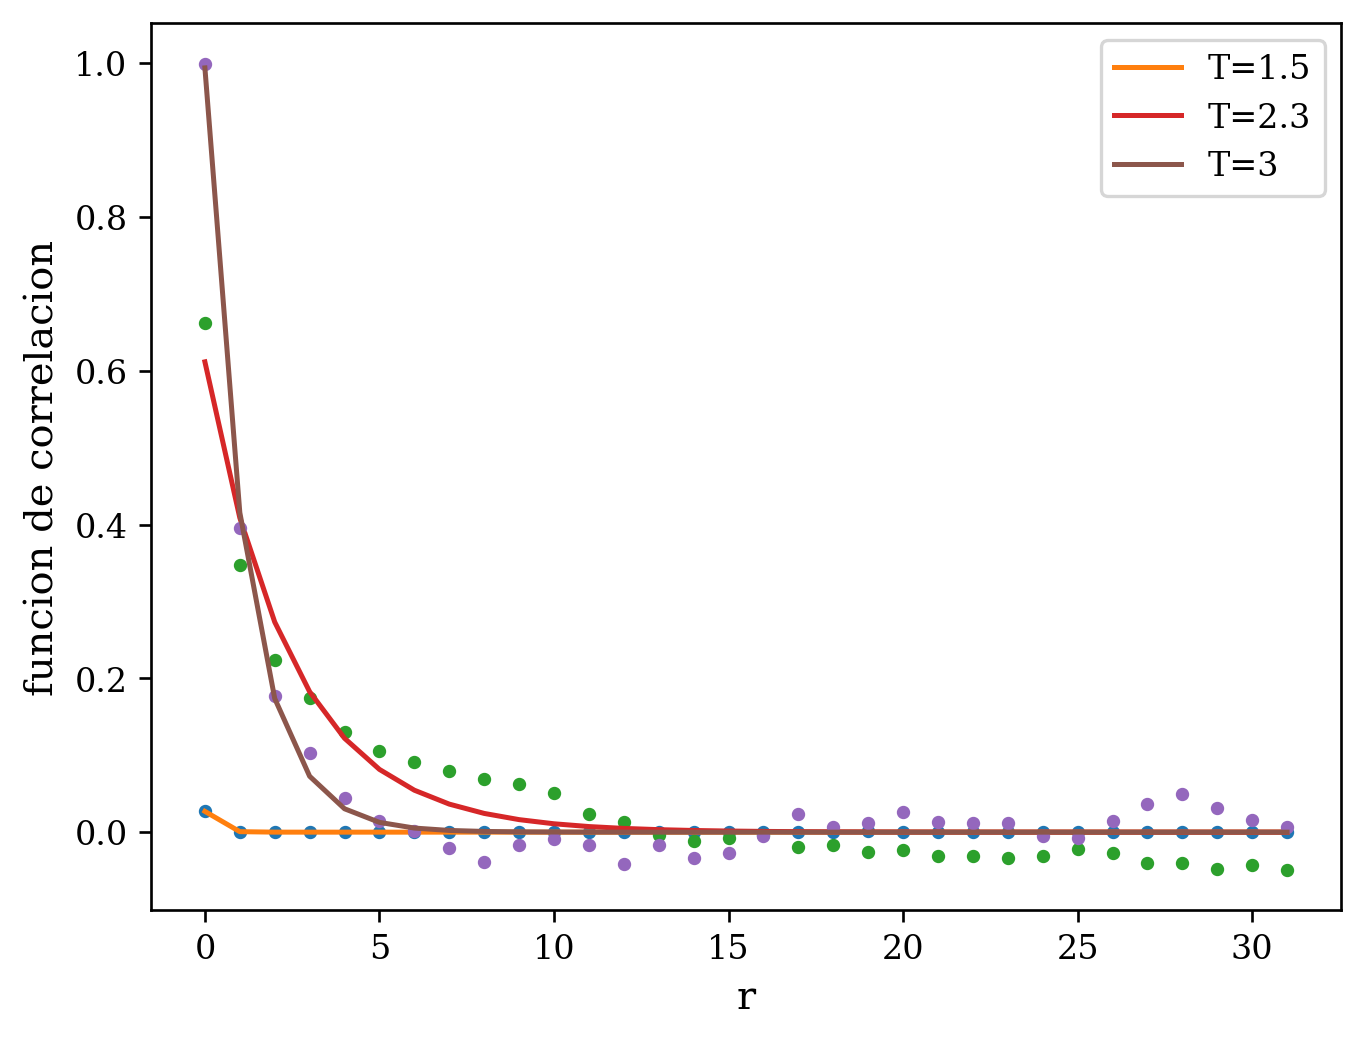

In [167]:
L = 64

nequilibrio = 10_000
npromedio = 1_000

l = L // 2  # numero de componentes del vector c
m = np.zeros(npromedio)  # magnetizacion en funcion del paso
c = np.zeros((l, npromedio))  # vector c en funcion del paso

r_vals = np.arange(l)  # dominio de la funcion de correlacion


def fitcor(r, a, xi):  # funcion con la que vamos a ajustar
    return a * np.exp(-r / xi)


S = np.ones((L, L), dtype=int)

print("Longitud de correlacion:")

for T in tqdm([1.5, 2.3, 3], desc="Temperaturas"):

    beta = 1 / T

    prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

    # Termalizamos con la funcion metropolis(S,prob), que es mas rapida
    for n in tqdm(range(nequilibrio), desc="Termalizando"):
        S, dm, de = metropolis(S, prob)

    m[0] = np.mean(S)
    c[:, 0] = cor_fft(S)

    for n in tqdm(range(1, npromedio), desc="Midiendo"):
        S, dm, dc = metropolis2_fft(S, prob)
        m[n] = m[n - 1] + dm
        c[:, n] = c[:, n - 1] + dc

    mmedia = np.mean(abs(m))
    correlacion = np.mean(c, axis=1) - mmedia**2  # funcion de correlacion

    # Ajustamos:
    parametros, covarianza = curve_fit(fitcor, r_vals, correlacion)
    # (la funcion curve_fit devuelve el mejor valor de los parametros
    # y tambien la covarianza, que no vamos a usar)

    print("T={} => {}".format(T, parametros[1]))

    plt.plot(r_vals, correlacion, ".")
    plt.plot(r_vals, fitcor(r_vals, *parametros), label="T={}".format(T))

plt.xlabel("r")
plt.ylabel("funcion de correlacion")
plt.legend()
plt.show()